In [1]:
## Import data and packages ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

In [2]:
## Upload data for error draws
draws = pd.read_csv('draw.out',sep='              ',header=None,engine='python')
draws = np.array(draws)

In [3]:
## Setup basic engine replacement model 
theta = np.array([0.3,0,4])
lam = 0.8
beta = 0.95

trans_matrix = sparse.diags([.2,.8],[0,1],shape=(11,11)).toarray()
trans_matrix[10,10]=1

def value_function0(x_t,params):
    val = -params[0]*x_t+-params[1]*x_t**2
    return val

def value_function1(params):
    val = -params[2]
    return val

## Define value function iteration algorithm

def iteration(epsilon,params,maxiter,n_steps):
    values_matrix = np.full((n_steps,n_steps),-100.)    
    values_temp = np.zeros(n_steps)
    values = np.ones(n_steps)
    state = np.linspace(0,10,n_steps)

    diff = 1
    i = 0
    while diff > epsilon:
        
        no_change = value_function0(state,params)
        change = value_function1(params)
        
        values_temp = .5772 + np.log(np.exp(no_change+beta*values)+np.exp(change+beta*values[0]))
        values_temp = values_temp.dot(trans_matrix.T)
        
        diff = np.linalg.norm(values - values_temp)
        values = values_temp
        i+=1
#         print(i)
        if i == maxiter:
            break
            print("Max Iterations Reached")
        
    return values, i, diff
    
results = iteration(.00001,theta,500,11)
print(results[0])

[-5.93269495 -6.83084801 -7.4876776  -7.95206643 -8.27516537 -8.49964733
 -8.65668353 -8.76757443 -8.84631755 -8.90005197 -8.90984461]


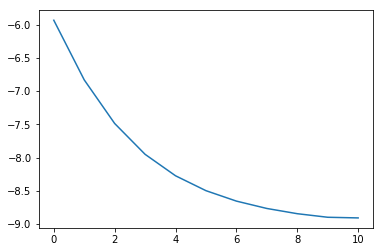

In [4]:
## plot values at each state
plt.plot(results[0])

[0.01798621 0.04608177 0.0951403  0.16539276 0.25225092 0.34872597
 0.44756102 0.54249324 0.62859249 0.69927235 0.75872387]


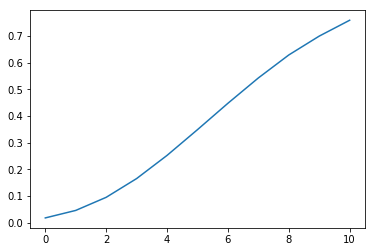

In [5]:
## Analytical Choice probability calculations
def choice_prob_calc(exp_vals,params):
    theta = params
    choice_prob_temp = np.zeros(11)
    v = exp_vals

    for i in range(11):
        state = i
        if state == 10:
            no_change = value_function0(state,theta) + beta*((1-lam)*v[state]+lam*v[state])
        else:
            no_change = value_function0(state,theta) + beta*((1-lam)*v[state]+lam*v[state+1])
        change = value_function1(theta) + beta*((1-lam)*v[0]+lam*v[1])
        choice_prob_temp[i] = np.exp(change)/(np.exp(no_change)+np.exp(change))
    return choice_prob_temp
        
choice_prob = choice_prob_calc(results[0],theta)
print(choice_prob)
plt.plot(choice_prob)

In [6]:
## Simulation Results
def simulator(exp_val,seed):
    v = exp_val
    state = 0
    mat_temp = np.zeros((5000,4)) 

    np.random.seed(seed)

    draws_log = -np.log(-np.log(draws))

    for i in range(5000):
        if state == 10:
            no_change = value_function0(state,theta) + beta*((1-lam)*v[state]+lam*v[state]) + draws_log[i,0]
        else:
            no_change = value_function0(state,theta) + beta*((1-lam)*v[state]+lam*v[state+1]) + draws_log[i,0]
        change = value_function1(theta) + beta*((1-lam)*v[0]+lam*v[1]) + draws_log[i,1]
        mat_temp[i,0]=state
        mat_temp[i,1]=no_change
        mat_temp[i,2]=change
        if no_change <  change:
            mat_temp[i,3] = 1
            state = 0
        else:
            mat_temp[i,3] = 0

        bi = np.random.binomial(1,p=.8)
        if state < 10:
            state += bi
        else:
            state = 10
    return mat_temp

choice_matrix = simulator(results[0],23)

In [7]:
## Calculate empirical choice probabilities from simulation
def f_choice_prob(mat,state):
    temp = mat[:,0]==state
    if temp.any():
        return mat[temp,3].mean()
    else:
        return 1
    
choice_prob_sim = np.zeros(11)    
for i in range(11):
    choice_prob_sim[i]=f_choice_prob(choice_matrix,i)
    print("State", i," average ",choice_prob_sim[i])

State 0  average  0.02242152466367713
State 1  average  0.04553734061930783
State 2  average  0.08301526717557252
State 3  average  0.17400881057268722
State 4  average  0.24533715925394547
State 5  average  0.352
State 6  average  0.4206896551724138
State 7  average  0.5496688741721855
State 8  average  0.5964912280701754
State 9  average  0.7
State 10  average  0.625


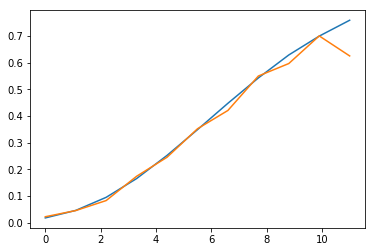

In [8]:
## plot empirical vs. analytical choice probablities
x = np.linspace(0,11,11)
plt.plot(x,choice_prob,x,choice_prob_sim)

In [9]:
## generate empirical cdf
def f_emp_cdf(mat,state):
    temp = mat[:,0] <= state
    count = temp.sum()
    return count
    
emp_cdf_sim = np.zeros(11)    
for i in range(11):
    emp_cdf_sim[i]=f_emp_cdf(choice_matrix,i)/5000
    print("State", i," average ",emp_cdf_sim[i])

State 0  average  0.0446
State 1  average  0.2642
State 2  average  0.4738
State 3  average  0.6554
State 4  average  0.7948
State 5  average  0.8948
State 6  average  0.9528
State 7  average  0.983
State 8  average  0.9944
State 9  average  0.9984
State 10  average  1.0


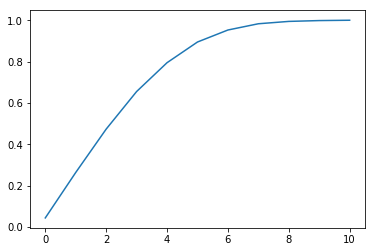

In [10]:
## plot empirical cdf
plt.plot(emp_cdf_sim)

In [11]:
## Define mle problem and setup estimate likelihood based on simulated results
def mle_estimator(params,epsilon,maxiter):
    
    theta = params
    print(theta)
    vals = iteration(epsilon,theta,500,11)
    
    choice_prob = np.zeros(11)
    v = vals[0]

    for i in range(11):
        state = i
        if state == 10:
            no_change = value_function0(state,theta) + beta*((1-lam)*v[state]+lam*v[state])
        else:
            no_change = value_function0(state,theta) + beta*((1-lam)*v[state]+lam*v[state+1])
        change = value_function1(theta) + beta*((1-lam)*v[0]+lam*v[1])
        choice_prob[i] = np.exp(change)/(np.exp(no_change)+np.exp(change))
    
    log_like = 0
    for i in range(5000):
        if i == 0:
            print(i)
        else:
            xt = int(choice_matrix[i,0])
            it = int(choice_matrix[i,3])
            xt_1 = int(choice_matrix[i-1,0])
            it_1 = int(choice_matrix[i-1,3])
            if it_1 == 1:
                if xt == 0:
                    p2 = .2
                else:
                    p2 = .8
            elif it_1 == 0:
                if xt == xt_1:
                    if xt == 10:
                        p2 = 1
                    else:
                        p2 = .2
                else:
                    p2 = .8
            if it == 1:
                p1 = choice_prob[xt]
            else:
                p1 = 1 - choice_prob[xt]
            log_like += np.log(p1*p2)
    
    return -log_like


In [12]:
## search parameter space to maximize log-likelihood
from scipy.optimize import fmin

mle_params1 = fmin(mle_estimator, theta, args=(.0001,500), xtol=0.0001, ftol=0.0001, maxiter=None)
print(mle_params1)

[0.3 0.  4. ]
0
[0.315 0.    4.   ]
0
[3.0e-01 2.5e-04 4.0e+00]
0
[0.3 0.  4.2]
0
[2.85000000e-01 1.66666667e-04 4.13333333e+00]
0
[3.07500000e-01 4.16666667e-05 4.03333333e+00]
0
[3.05000000e-01 1.94444444e-04 3.82222222e+00]
0
[3.01250000e-01 4.86111111e-05 4.10555556e+00]
0
[2.93333333e-01 1.57407407e-04 4.03703704e+00]
0
[2.86250000e-01 2.15277778e-04 4.03888889e+00]
0
[ 2.96388889e-01 -1.12654321e-04  4.09506173e+00]
0
[2.99097222e-01 1.59336420e-04 4.02376543e+00]
0
[2.93703704e-01 1.62551440e-04 3.93497942e+00]
0
[2.99363426e-01 7.70961934e-05 4.06291152e+00]
0
[2.94529321e-01 2.62560014e-04 4.08247599e+00]
0
[2.98632330e-01 6.56400034e-05 4.02061900e+00]
0
[2.95122171e-01 4.07593164e-05 4.05661294e+00]
0
[2.98103459e-01 1.29692144e-04 4.03197731e+00]
0
[3.04066144e-01 2.42114864e-05 4.03996818e+00]
0
[2.96016536e-01 1.24108427e-04 4.03776982e+00]
0
[2.95804791e-01 1.35864190e-04 3.99733256e+00]
0
[2.98473767e-01 9.17881925e-05 4.04651678e+00]
0
[2.96430178e-01 1.64752506e-04 4.

In [13]:
## use estimated parameters to find LR replacement probability
# Method 1: Simulation
EVs = iteration(.0001,mle_params1,500,11)
choice_prob2 = choice_prob_calc(EVs[0],mle_params1)
choice_matrix2 = simulator(EVs[0],23)
def f_state_prob(mat,state):
    temp = mat[:,0] == state
    count = temp.sum()
    return count
state_prob_sim = np.zeros(11)
for i in range(11):
    state_prob_sim[i]=f_state_prob(choice_matrix2,i)/5000
LR_rep_prob1 = np.sum(state_prob_sim.T.dot(choice_prob2))
print(LR_rep_prob1)

0.18053572812545082


In [14]:
## use estimated parameters to find LR replacement probability
# Method 2: Analytical
EVs = iteration(.0001,mle_params1,500,11)
choice_prob2 = choice_prob_calc(EVs[0],mle_params1)
markov_trans_matrix = np.zeros((11,11))
for i in range(11):
    chg_0 = choice_prob2[i]*.2
    chg_1 = choice_prob2[i]*.8
    nchg_0 = (1-choice_prob2[i])*.2
    nchg_1 = (1-choice_prob2[i])*.8
    if i != 10:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i+1]+=nchg_1
    else:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i]+=nchg_1
        
Q_temp = np.zeros(11)
Q_temp[0]=1
Q = np.ones(11)
Q_n = np.zeros(11)
while np.linalg.norm(Q-Q_n)>.001:
    Q=Q_temp
    Q_n=Q.dot(markov_trans_matrix.T)
    Q_temp=Q_n
    print(np.linalg.norm(Q-Q_n))
LR_rep_prob2 = np.sum(Q.T.dot(choice_prob2))
print("LR Replacement Probability:",LR_rep_prob2)

0.8496191828738736
0.1863889158561775
0.07986155262938627
0.03240239722596804
0.016435459337221025
0.015064994834799726
0.01163254573973083
0.0064009215887337375
0.0033064941770365617
0.0032235207203666102
0.002615120485046768
0.0014125643804359638
0.0007434730675536262
LR Replacement Probability: 0.17329020635332243


In [15]:
## Policy exercise
# What is the effect of a 10% reduction on replacement costs on LR replacement probability
theta_policy = mle_params1
theta_policy[2] = theta[2]*.9
EVs = iteration(.0001,theta_policy,500,11)
choice_prob2 = choice_prob_calc(EVs[0],theta_policy)
markov_trans_matrix = np.zeros((11,11))
for i in range(11):
    chg_0 = choice_prob2[i]*.2
    chg_1 = choice_prob2[i]*.8
    nchg_0 = (1-choice_prob2[i])*.2
    nchg_1 = (1-choice_prob2[i])*.8
    if i != 10:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i+1]+=nchg_1
    else:
        markov_trans_matrix[i,0]+=chg_0
        markov_trans_matrix[i,1]+=chg_1
        markov_trans_matrix[i,i]+=nchg_0
        markov_trans_matrix[i,i]+=nchg_1
        
Q_temp = np.zeros(11)
Q_temp[0]=1
Q = np.ones(11)
Q_n = np.zeros(11)
while np.linalg.norm(Q-Q_n)>.001:
    Q=Q_temp
    Q_n=Q.dot(markov_trans_matrix.T)
    Q_temp=Q_n
    print(np.linalg.norm(Q-Q_n))
LR_rep_prob2 = np.sum(Q.T.dot(choice_prob2))
print("LR Replacement Probability:",LR_rep_prob2)
print(choice_prob2)

0.8589253519069626
0.19373195517356842
0.079645528817965
0.028021370034494092
0.015777872735576855
0.014246748730878618
0.00920044916311383
0.004046543419972709
0.002696731624706414
0.002562690283768078
0.0015523050055921952
0.0006495229688864157
LR Replacement Probability: 0.21608731578831902
[0.02659699 0.0647088  0.12622385 0.20788843 0.30208893 0.40034849
 0.49552619 0.58265599 0.65870376 0.71951595 0.76962135]


In [17]:
## Policy Effect
print("Policy Increases LR Replacement Probability by",(0.21608731578831902-0.17329020635332243)/0.17329020635332243*100,"%")

Policy Increases LR Replacement Probability by 24.696784853344404 %
